In [1]:
# import dependancies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [2]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# view all classes found
Base.classes.keys()

['measurement', 'station']

In [5]:
# save references to each respective table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# create our session (link) from Python to the DB
session = Session(engine)

In [7]:
# use inspect function to get column names
measure_inspector = inspect(engine)
measure_columns = measure_inspector.get_columns('Measurement')

for column in measure_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# use inspect function to get column names
station_inspector = inspect(engine)
station_columns = station_inspector.get_columns('Station')
for column in station_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# find most recent date within the data
recent = session.query(Measurement).order_by(Measurement.date.desc()).first()
print(recent.date)

2017-08-23


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# retrieve the data and precipitation scores from last year til date
sel = [Measurement.date, func.sum(Measurement.prcp)]
year_data = session.query(*sel).filter(func.strftime(Measurement.date)>=dt.date(2016, 8, 23)).\
    order_by(Measurement.date).group_by(Measurement.date).all()

# save the results as a df
df = pd.DataFrame(year_data, columns=['date', 'prcp'])
df = df.set_index('date')
df.head()

,prcp
date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32


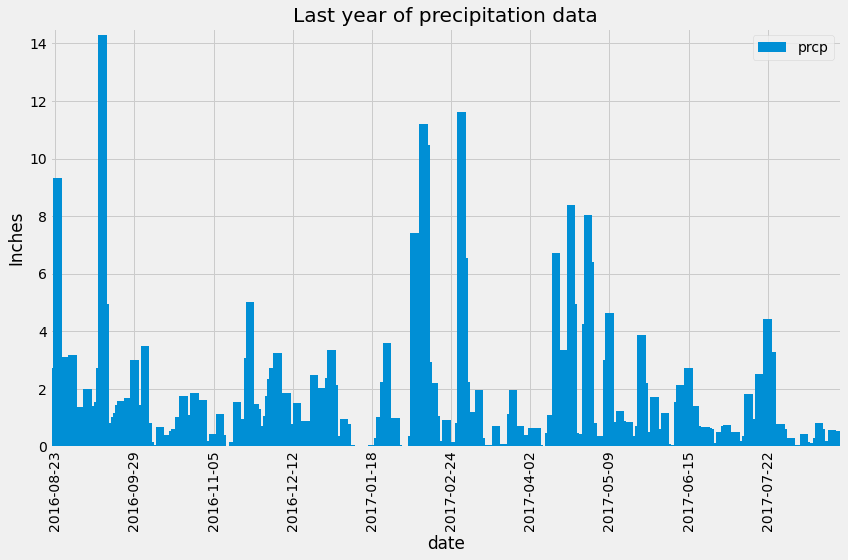

In [11]:
# plot the data via Pandas and Matplotlib
graph = df.plot(kind="bar", figsize=(12,8), ylabel="Inches", ylim=(0,(df['prcp'].max()+0.25)),
                            title="Last year of precipitation data", width=4)
plt.locator_params(nbins=10)
plt.tight_layout()

In [12]:
# calculate the summary for the data
df.describe()

,prcp
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


In [13]:
# query total number of stations in data
total = session.query(Station).count()
total

9

In [14]:
# find the most active stations
sel = [Station.station, func.count(Station.id)]
activity_count = session.query(*sel).filter(Measurement.station == Station.station).group_by(Station.id).all()
df = pd.DataFrame(activity_count, columns=['Station', 'Count of Activity'])
df.sort_values('Count of Activity', ascending=False)

,Station,Count of Activity
6,USC00519281,2772
0,USC00519397,2724
1,USC00513117,2709
5,USC00519523,2669
8,USC00516128,2612
2,USC00514830,2202
7,USC00511918,1979
3,USC00517948,1372
4,USC00518838,511


In [15]:
# calculate average, lowest, and highest temp from most used station
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
temp = session.query(*sel).filter(Measurement.station == 'USC00519281').all()
print(f"The lowest temp at station USC00519281 was {temp[0][0]}.")
print(f"The highest temp at station USC00519281 was {temp[0][1]}.")
print(f"The average temp at station USC00519281 was {round(temp[0][2],1)}.")

The lowest temp at station USC00519281 was 54.0.
The highest temp at station USC00519281 was 85.0.
The average temp at station USC00519281 was 71.7.


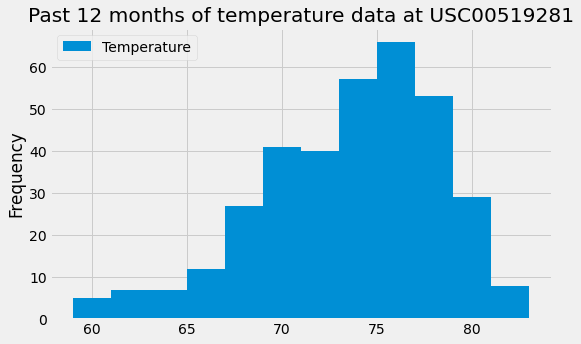

In [16]:
# use last 12 months of data and plot histogram
temp = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281', 
                                              func.strftime(Measurement.date)>=dt.date(2016, 8, 23)).all()
df = pd.DataFrame(temp, columns=['Temperature'])
temp_plot = df.plot(kind="hist", figsize=(8,5), xlabel='Temperature', ylabel="Frequency", bins=12, 
                          title="Past 12 months of temperature data at USC00519281")

In [17]:
# close Session
session.close()